# Main Assignment Conditions

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler


from sklearn.compose import make_column_transformer
import sklearn.metrics as metrics
from collections import Counter

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier


from imblearn.over_sampling import RandomOverSampler

import imblearn

from imblearn.pipeline import Pipeline, make_pipeline

### Contract DataFrame:

In [31]:
try:
     contract = pd.read_csv('contract.csv')
        
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')

contract.sample(4)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4918,6582-PLFUU,2015-11-01,No,Two year,No,Credit card (automatic),19.55,1086.75
5031,8118-TJAFG,2019-05-01,No,Month-to-month,Yes,Electronic check,101.50,906.85
3969,2920-RNCEZ,2020-01-01,No,Month-to-month,Yes,Credit card (automatic),69.95,69.95
3933,5396-IZEPB,2019-05-01,No,Month-to-month,No,Credit card (automatic),19.70,180.7


In [32]:
print("Duplicated rows in contract table:", contract[contract.duplicated()].shape[0])
print()
print(contract.info())

Duplicated rows in contract table: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


In [33]:
# Examine the rest of the columns in contract table:
print(contract['EndDate'].value_counts(normalize=True))
print()
print(contract['Type'].value_counts(normalize=True))
print()
print(contract['PaperlessBilling'].value_counts(normalize=True))
print()
print(contract['PaymentMethod'].value_counts(normalize=True))

No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: EndDate, dtype: float64

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: Type, dtype: float64

Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: PaymentMethod, dtype: float64


* Columns:  Type,  PaperlessBilling, and PaymentMethod are categoriacl features, their values are not balance but they are on the same scale(magnetude).
* EndDate column is the target, and its imbalanced. there are 5174 customers without contract end date, and 1869 customers with contract end date. 
* There are no duplicates

**Change the columns type:**
* 'BeginDate' and  'EndDate' columns into datetime,
* 'TotalCharges' into float,
* 'PaperlessBilling' column: turn ['Yes','No']  into [1,0],
* 'Type' column: turn ['Month-to-month', 'One year', 'Two year'] into [0, 1, 2],
* 'PaymentMethod' column: turn ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'] into [0, 1, 2, 3].

In [34]:
contract['BeginDate'] =  pd.to_datetime(contract['BeginDate'])

contract['EndDate'] =  pd.to_datetime(contract['EndDate'], errors= 'coerce')

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'],errors= 'coerce', downcast="float")

contract['PaperlessBilling'] = contract['PaperlessBilling'].map({'Yes':1, 'No':0}) 

contract['Type']=contract['Type'].map({'Month-to-month':0, 'One year':1, 'Two year':2})

contract['PaymentMethod']=contract['PaymentMethod'].map({'Electronic check':0,
                                                         'Mailed check':1,
                                                         'Bank transfer (automatic)':2,
                                                         'Credit card (automatic)':3})
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,0,1,0,29.85,29.850000
1,5575-GNVDE,2017-04-01,NaT,1,0,1,56.95,1889.500000
2,3668-QPYBK,2019-10-01,2019-12-01,0,1,1,53.85,108.150002
3,7795-CFOCW,2016-05-01,NaT,1,0,2,42.30,1840.750000
4,9237-HQITU,2019-09-01,2019-11-01,0,1,0,70.70,151.649994


**Create new column ContractDuration:**

In [35]:
curent_date = datetime(2020, 2, 1)

contract['ContractDuration']=np.where(contract['EndDate'].isnull(),
                                      curent_date- contract['BeginDate'],
                                      contract['EndDate']-contract['BeginDate'])

contract['ContractDuration']=round(contract['ContractDuration']/np.timedelta64(1, 'M'))
contract.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration
0,7590-VHVEG,2020-01-01,NaT,0,1,0,29.85,29.85,1.0
1,5575-GNVDE,2017-04-01,NaT,1,0,1,56.95,1889.50,34.0


**Create new column- Target, with value of 0 if the customer contract has end date and 1 if not:**

In [36]:
contract['target']=np.where(contract['EndDate'].isnull(), 0, 1)
contract.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,target
0,7590-VHVEG,2020-01-01,NaT,0,1,0,29.85,29.85,1.0,0
1,5575-GNVDE,2017-04-01,NaT,1,0,1,56.95,1889.50,34.0,0


In [37]:
# Check for missing values: 
contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
ContractDuration       0
target                 0
dtype: int64

In [38]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,target
488,4472-LVYGI,2020-02-01,NaT,2,1,2,52.55,NaN,0.0,0
753,3115-CZMZD,2020-02-01,NaT,2,0,1,20.25,NaN,0.0,0
936,5709-LVOEQ,2020-02-01,NaT,2,0,1,80.85,NaN,0.0,0
1082,4367-NUYAO,2020-02-01,NaT,2,0,1,25.75,NaN,0.0,0
1340,1371-DWPAZ,2020-02-01,NaT,2,0,3,56.05,NaN,0.0,0
3331,7644-OMVMY,2020-02-01,NaT,2,0,1,19.85,NaN,0.0,0
3826,3213-VVOLG,2020-02-01,NaT,2,0,1,25.35,NaN,0.0,0
4380,2520-SGTTA,2020-02-01,NaT,2,0,1,20.00,NaN,0.0,0
5218,2923-ARZLG,2020-02-01,NaT,1,1,1,19.70,NaN,0.0,0
6670,4075-WKNIU,2020-02-01,NaT,2,0,1,73.35,NaN,0.0,0


* The instruction said "The contract information is valid as of February 1, 2020"  all the missing values belonge for customers that thier constract start at February 1, 2020. Im going to set thos missing values as 0.

In [39]:
contract['TotalCharges'].fillna(0, inplace=True)

In [40]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   int64         
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   int64         
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float32       
 8   ContractDuration  7043 non-null   float64       
 9   target            7043 non-null   int32         
dtypes: datetime64[ns](2), float32(1), float64(2), int32(1), int64(3), object(1)
memory usage: 495.3+ KB


**lets take a look at the numerical columns distribution:**

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

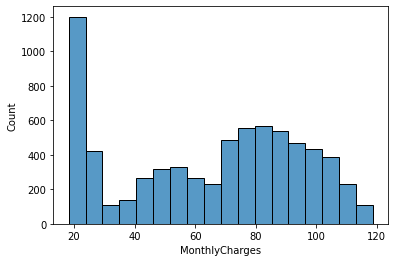

In [41]:
sns.histplot(data=contract, x='MonthlyCharges', stat='count')

* In the graph above we can see bivariate distribution, the first around monthly charge of 20, and the seconde around monthly charge of 80, Its make sense. Not all the customers paying for the same services.

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

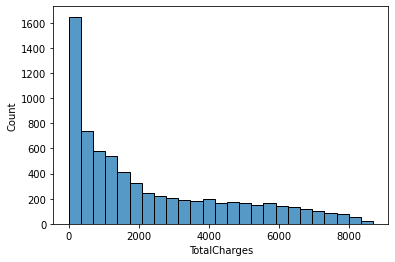

In [42]:
sns.histplot(data=contract, x='TotalCharges', stat='count')

* In the graph above we can see left skewed  distribution with pick around total charge of 400, and max total charge that exeed 8000.

<AxesSubplot:xlabel='ContractDuration', ylabel='Count'>

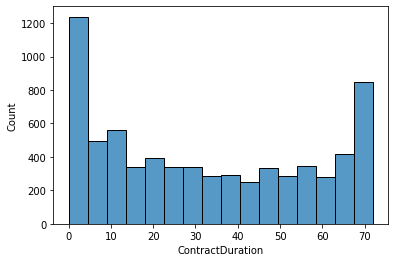

In [43]:
sns.histplot(data=contract, x='ContractDuration', stat='count')

* In the graph above we can see the contract duration for  Interconnect operator customers. We can see bivariate distribution- one around 2.5 months and the seconde around 70 months. Ther are two kinds of customers: new ones and some that stay loyal for a long period of time. 


In [44]:
# Set 'customerID' and 'target' columns to add the other tables:  
target = contract[['customerID','target']]

### Personal DataFrame:

In [45]:
try:
     personal = pd.read_csv('personal.csv')
        
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    
personal.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No


In [46]:
print("Duplicated rows in personal table:", personal[personal.duplicated()].shape[0])
print()
print(personal.info())

Duplicated rows in personal table: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [47]:
# Examine the contact of the columns in personal table:
print(personal['gender'].value_counts(normalize=True))
print()
print(personal['SeniorCitizen'].value_counts(normalize=True))
print()
print(personal['Partner'].value_counts(normalize=True))
print()
print(personal['Dependents'].value_counts(normalize=True))
print()

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64



* The personal dataframe contain:
    * customerID coulumn that link it to the contarct datafram
    * 5 boolian columns for gender, SeniorCitizen, Partner, Dependents.
    * There is no missing values and no duplicated rows.
    * The gender and Partner columns are balanced 
    * The SeniorCitizen and Dependents columns aer imbalanced but it make sense that senior citizen and dependent people won't have the equale share in the population.
    * There are no duplicates or missing values. 

**Change the categorical values into numeric values:**

* 'gender' column: turn ['Male','Female'] into [1,0]
* 'Partner' column: turn ['Yes', 'No'] into [0, 1,]
* 'Dependents' column: turn ['Yes', 'No'] into [0, 1]

In [48]:
personal['gender'] = personal['gender'].map({'Male':1, 'Female':0})
personal['Partner'] = personal['Partner'].map({'Yes':1, 'No':0}) 
personal['Dependents'] = personal['Dependents'].map({'Yes':1, 'No':0}) 
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


### Internet DataFrame:

In [49]:
try:
     internet = pd.read_csv('internet.csv')
        
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')

internet.sample(4)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3557,5914-XRFQB,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
2425,3911-RSNHI,DSL,No,Yes,Yes,Yes,Yes,Yes
4293,3374-TTZTK,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
2158,9086-YJYXS,DSL,No,No,Yes,No,Yes,Yes


In [50]:
print("Duplicated rows in internet table:", internet[internet.duplicated()].shape[0])
print()
print(internet.info())

Duplicated rows in internet table: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


In [51]:
# Examine the contact of the columns in Internet table:
columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 
           'TechSupport', 'StreamingTV', 'StreamingMovies']
for c in columns:
    print(internet[c].value_counts(normalize=True))
    print()

Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

No     0.63404
Yes    0.36596
Name: OnlineSecurity, dtype: float64

No     0.559724
Yes    0.440276
Name: OnlineBackup, dtype: float64

No     0.560993
Yes    0.439007
Name: DeviceProtection, dtype: float64

No     0.629509
Yes    0.370491
Name: TechSupport, dtype: float64

No     0.509335
Yes    0.490665
Name: StreamingTV, dtype: float64

No     0.504803
Yes    0.495197
Name: StreamingMovies, dtype: float64



* InternetService, OnlineBackup, DeviceProtection, StreamingTV, and StreamingMovies colums are balanced 
* OnlineSecurity, TechSupport columns are not balance. lets kepp that in mind for now. 
* There are no duplicase or missing values. 

**Change the categorical values into numeric values:**

* 'InternetService' column: turn ['Fiber optic','SDL'] into [1,0]
* 'OnlineSecurity' column: turn ['Yes', 'No'] into [0, 1,]
* 'OnlineBackup' column: turn ['Yes', 'No'] into [0, 1]
* 'DeviceProtection' column: turn ['Male','Female'] into [1,0]
* 'TechSupport' column: turn ['Yes', 'No'] into [0, 1,]
* 'StreamingTV' column: turn ['Yes', 'No'] into [0, 1]
* 'StreamingMovies' column: turn ['Yes', 'No'] into [0, 1]

In [52]:
columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for column in columns:
    internet[column]=internet[column].map({'Yes':1, 'No':0}) 
    
internet['InternetService']=internet['InternetService'].map({'Fiber optic':1, 'DSL':0})
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,0,0,1,0,0,0,0
1,5575-GNVDE,0,1,0,1,0,0,0
2,3668-QPYBK,0,1,1,0,0,0,0
3,7795-CFOCW,0,1,0,1,1,0,0
4,9237-HQITU,1,0,0,0,0,0,0


In [53]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   int64 
 2   OnlineSecurity    5517 non-null   int64 
 3   OnlineBackup      5517 non-null   int64 
 4   DeviceProtection  5517 non-null   int64 
 5   TechSupport       5517 non-null   int64 
 6   StreamingTV       5517 non-null   int64 
 7   StreamingMovies   5517 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 344.9+ KB


### Phone DataFrame:

In [55]:
try:
     phone = pd.read_csv('phone.csv')
        
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
phone.sample(4)

,customerID,MultipleLines
2168,6650-BWFRT,Yes
3971,9896-UYMIE,Yes
1030,3156-QLHBO,No
1587,0106-GHRQR,Yes


In [56]:
print("Duplicated rows in phone table:", phone[phone.duplicated()].shape[0])
print()
print(phone.info())
phone.describe().T

Duplicated rows in phone table: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


* The MultipleLines column are quiet balanced. 
* There are no duplicats and no missing values. 

**Change the categorical values into numeric values:**

* 'MultipleLines' column: turn ['Fiber optic','SDL'] into [1,0]

In [57]:
phone['MultipleLines']=phone['MultipleLines'].map({'Yes':1, 'No':0})

In [58]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


In [59]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


In [60]:
merge1 = pd.merge(contract,
                  personal,
                  how="outer",
                  on = 'customerID')

merge2 = pd.merge(merge1,
                  internet,
                  how="outer",
                  on = 'customerID')

merge = pd.merge(merge2,
                 phone,
                 how="outer",
                 on = 'customerID')

merge.shape

(7043, 22)

In [61]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   int64         
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   int64         
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float32       
 8   ContractDuration  7043 non-null   float64       
 9   target            7043 non-null   int32         
 10  gender            7043 non-null   int64         
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   int64         
 13  Dependents        7043 non-null   int64         
 14  InternetService   5517 n

* The reason we have missing values is that thos customers does not are did not signed for Internet, or phone. That's the reasone Im filling the missing values with zeros

In [62]:
merge.fillna(0, inplace=True)
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   int64         
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   int64         
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float32       
 8   ContractDuration  7043 non-null   float64       
 9   target            7043 non-null   int32         
 10  gender            7043 non-null   int64         
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   int64         
 13  Dependents        7043 non-null   int64         
 14  InternetService   7043 n

In [63]:
merge.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,target,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,0,0,1,0,29.85,29.850000,1.0,0,...,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,2017-04-01,0,1,0,1,56.95,1889.500000,34.0,0,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,1,53.85,108.150002,2.0,1,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,0,1,0,2,42.30,1840.750000,45.0,0,...,0,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,0,70.70,151.649994,2.0,1,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


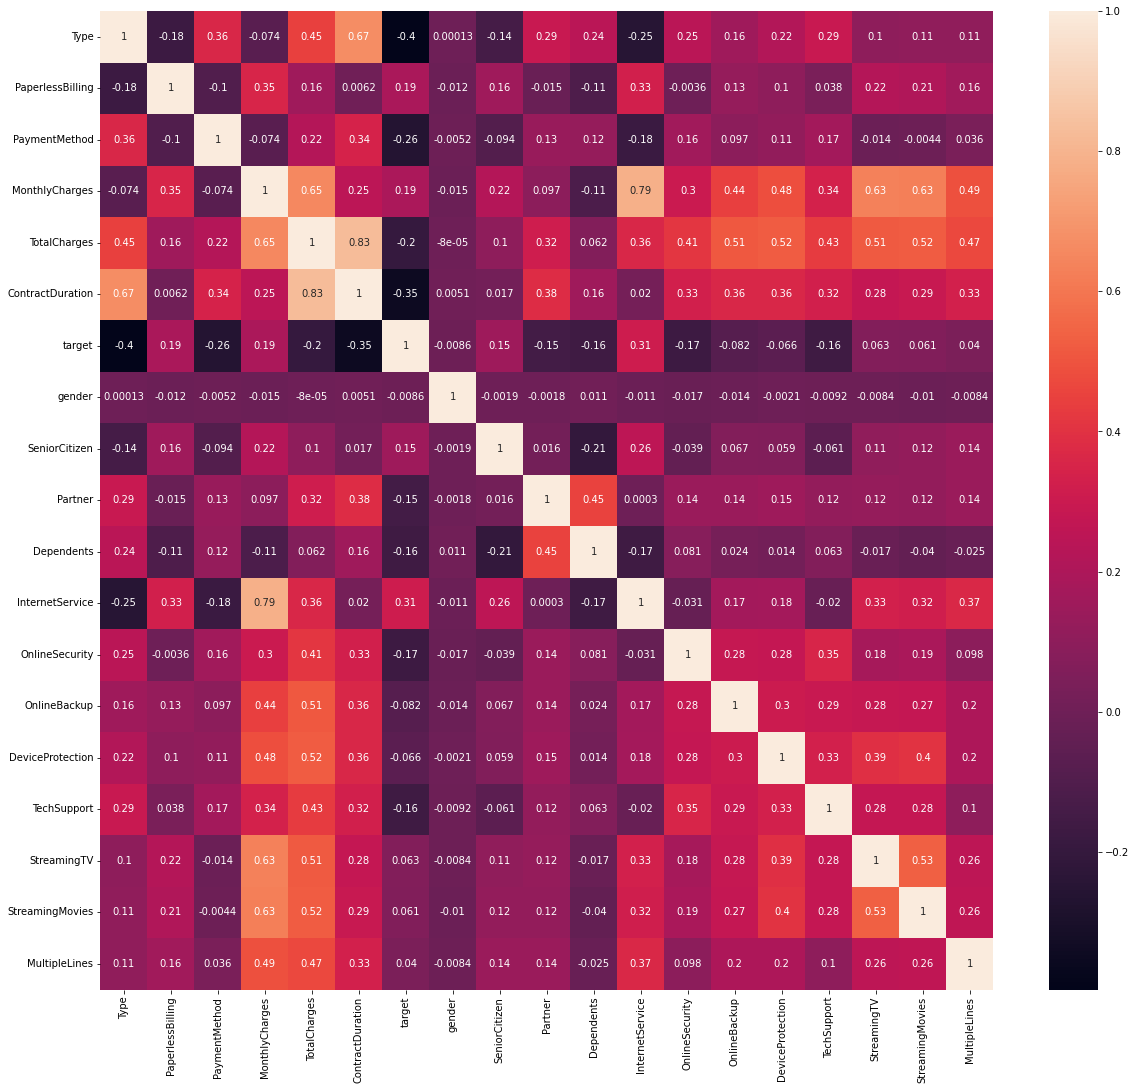

In [64]:
#checking for correlation
plt.figure(figsize=(20,18))
corr=merge.corr()
sns.heatmap(corr,annot=True);

* In the figure above we can see the correlation between the different columns, this correlation relevent for regression.
    * InternetService and MonthlyCharges columns have 0.79 correlation 
    * ContractDuration and TotalCharges columns have 0.83 correlation, which ,make sense. 
    * MonthlyCharges and StreamTv/StreamMovies columns have 0.633 correlation 
* By looking at the correlation  between the target(target column) and the features(the rest of the columns):
    * The highest values are: Type column with 0.4 correlation and ContractDuration with 0.35 correlation.
    * We created the ContractDuration column base on the EndDate column which is the target column, we risking with target leakage, the fact that the correlation is not that high is reassuring  
    * The rest of columns have pretty low correlation, since we don't have otherc option for features Im going to try and train a model based on this features.  

**Create new data base with the relevant columns for model:**

In [65]:
df=merge.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [66]:
# Transform the the categorical columns with more then two calss with One Hot encoder: 
transformer = make_column_transformer((OneHotEncoder(), 
                                       ['Type', 'PaymentMethod']), 
                                      remainder='passthrough')

transformed = transformer.fit_transform(df)
columns =['pay_type_2years', 'pay_type_1year', 'pay_type_month_to_month', 
          'pay_meth_electro_check', 'pay_meth_mailed_check', 'pay_meth_bank_trans', 'pay_meth_card',
          'PaperlessBilling', 'MonthlyCharges','TotalCharges', 'ContractDuration', 'target', 'gender',
          'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
          'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

df = pd.DataFrame(transformed, columns=columns)

**Split the data  to features(x) and target(y) and to train validation and test set:**

In [67]:
x = df.drop(['target'], axis=1)
y = df['target']
x_train, x_remain, y_train, y_remain = train_test_split(x, y, test_size=0.4, random_state=12345)
x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, test_size=0.5, random_state=12345)

**Define upsample function to balance the the different classes obsevation on train set:**

In [68]:
def upsample(features, target):
    class_0_len= sum(target==0)
    class_1_len= sum(target==1)
    repeat = round(class_0_len/class_1_len)
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [69]:
up_x_train, up_y_train= upsample(x_train, y_train)
counter_up = Counter(up_y_train)
print('upsample target for regression train set:', counter_up)

upsample target for regression train set: Counter({1.0: 3303, 0.0: 3124})


In [70]:
# copy of datasets
x_train_up_stand = up_x_train.copy()
x_train_stand = x_train.copy()
x_val_stand = x_val.copy()
x_test_stand = x_test.copy()

# numerical features
num_cols = ['MonthlyCharges','TotalCharges','ContractDuration']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data columns:
    scale = StandardScaler().fit(x_train_stand[[i]])
    
    # transform the training data columns:
    x_train_stand[i] = scale.transform(x_train_stand[[i]])

    # transform the training upSampled data columns:
    x_train_up_stand[i] = scale.transform(x_train_up_stand[[i]])
    
    # transform the validation data columns:
    x_val_stand[i] = scale.transform(x_val_stand[[i]])
    
    # transform the testing data column
    x_test_stand[i] = scale.transform(x_test_stand[[i]])


**Normalize the features:**
* Leaving the target column untuoched.
* Applying normalization one separated data set to prevent leakage.
* Using normalization instead od standardization since the the numerical columns does not  have Gaussian distribution and I dont want to change that.   

In [71]:
norm = MinMaxScaler().fit(x_train)

x_train_norm = norm.transform(x_train)
x_val_norm = norm.transform(x_val)
x_test_norm = norm.transform(x_test)

x_train_up_norm = norm.transform(up_x_train)

### Mnipulated DF Summary: 
**Encoded data:**
* x_train           * x_val        * x_test        * y_train        * y_val    * y_test

**Encoded UpSampled data:**
* up_x_train        * x_val        * x_test        * up_y_train      * y_val   * y_test

**Encoded Standardized data:**
* x_train_stand      * x_val_stand  * x_test_stand  * y_train         * y_val    * y_test

**Encoded Standardized UpSampled data:**
* x_train_up_stand  * x_val_stand  * x_test_stand  * up_y_train      * y_val    * y_test

**Encoded Normalized data:**
* x_train_norm      * x_val_norm   * x_test_norm   * y_train         * y_val    * y_test

**Encoded Normalized UpSampled data:**
* x_train_up_norm   * x_val_norm   * x_test_norm   * up_y_train      * y_val    * y_test

# Clarification: Summary

Target feature: the `'EndDate'` column equals `'No'`.

Primary metric: AUC-ROC[AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) ]

Additional metric: Accuracy.

Assessment criteria:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

**Define evaluate_model function that print the evaluation metrics- Accuracy, F1, APS, ROC-AUC:**

In [72]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target),
                                   ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds,
                f1_scores, color=color,
                label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], 
                    f1_scores[closest_value_idx], 
                    color=marker_color, marker='X', 
                    markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

**DummyClassifier (strategy='most_frequent'):**

          train  test
Accuracy   0.87  0.76
F1         0.88  0.65
APS        0.92  0.65
ROC AUC    0.93  0.85


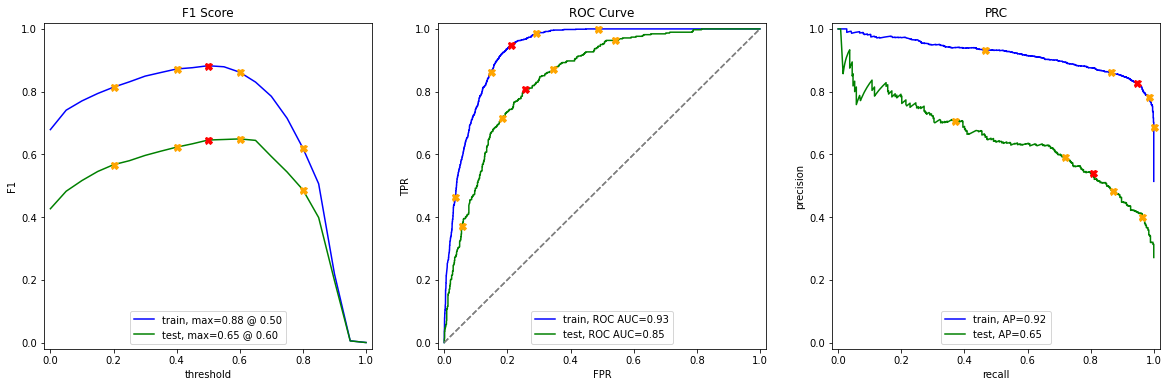

In [73]:
rf_model = RandomForestClassifier(random_state=12345,
                                  n_estimators= 8,
                                  max_depth= 9)
rf_model.fit(x_train_up_stand, up_y_train)
evaluate_model(rf_model, x_train_up_stand, up_y_train, x_val_stand, y_val)

          train  test
Accuracy   0.74  0.73
F1         0.00  0.00
APS        0.26  0.27
ROC AUC    0.50  0.50


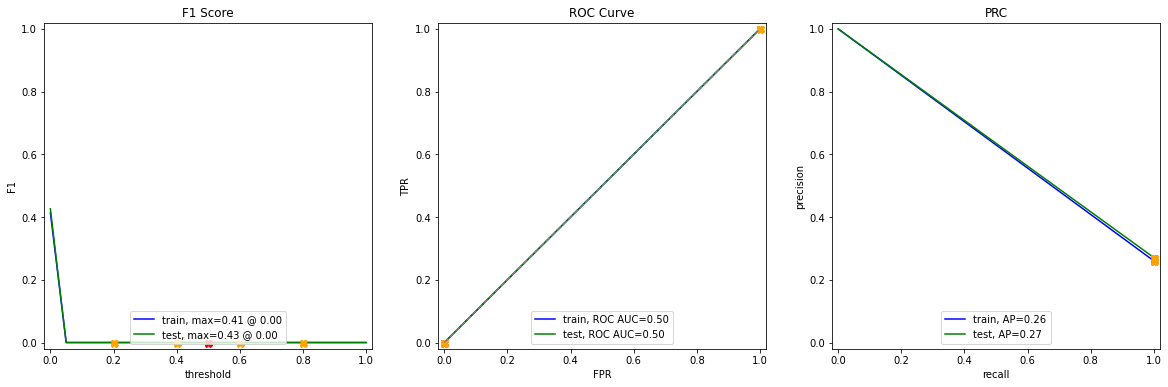

In [74]:
model_dummy = DummyClassifier(strategy='most_frequent')
model_dummy.fit(x_train, y_train)

evaluate_model(model_dummy, x_train, y_train, x_val, y_val)

* To get base line: we used dummy model who predict according the most frequent calss- which mean the client not going to leave Telcom operator. 
* In that case we get Accuracy of 0.73 (the share of customers without end date) and ROC AOC of 0.5. 


**LogisticRegression for upsampled data and normalized features:**

          train  test
Accuracy   0.77  0.75
F1         0.79  0.64
APS        0.84  0.66
ROC AUC    0.85  0.85


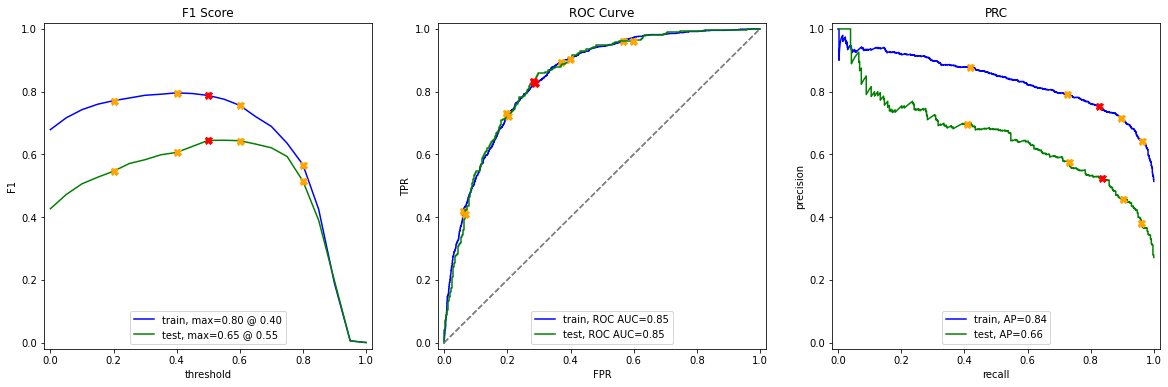

In [75]:
model_lr1 = LogisticRegression(random_state=12345)
model_lr1.fit(x_train_up_norm, up_y_train)
evaluate_model(model_lr1, x_train_up_norm, up_y_train, x_val_norm, y_val)

* For Logistic Regression with upsamled normalize and encoded data:
    * The AOC-ROC is 0.85 and the accuracy is 0.74 for the test set wich is pretty close to the base line model score.
    * The diffrences between the F1 and the APS score the for tarin and the test is alarming.  

**LogisticRegression for Standardized features:**

          train  test
Accuracy   0.75  0.75
F1         0.63  0.64
APS        0.65  0.66
ROC AUC    0.85  0.85


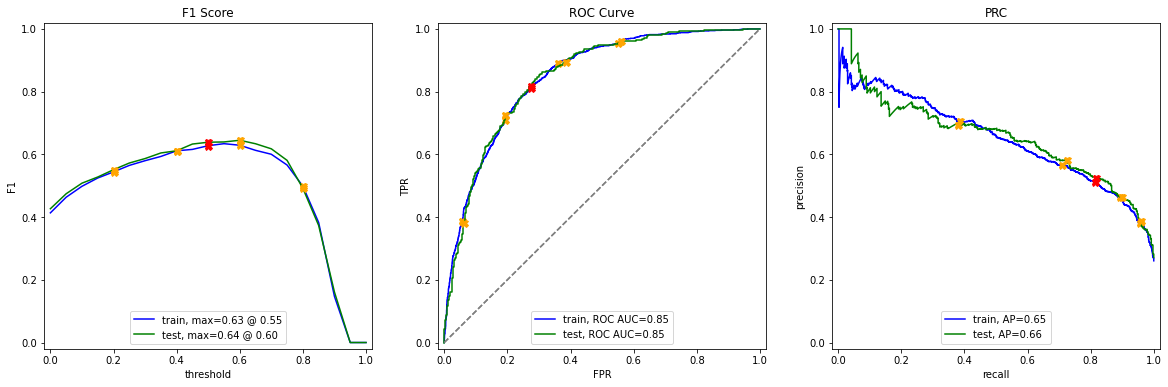

In [76]:
model_lr2 = LogisticRegression(class_weight = 'balanced', random_state=12345)
model_lr2.fit(x_train_stand, y_train)
evaluate_model(model_lr2, x_train_stand, y_train, x_val_stand, y_val)

* For Logistic Regression with Standardized and encoded data, with class_wight set as balanced:
    * the AOC-ROC is 0.85 and the accuracy is 0.74 for the test set wich is pretty close to the base line model score, same as before.
    * There is no diffrences between the F1 and the APS score the for tarin and the test they both are low.  

**LogisticRegression for upsampled data and Standardized features:**

          train  test
Accuracy   0.77  0.75
F1         0.79  0.64
APS        0.84  0.66
ROC AUC    0.85  0.85


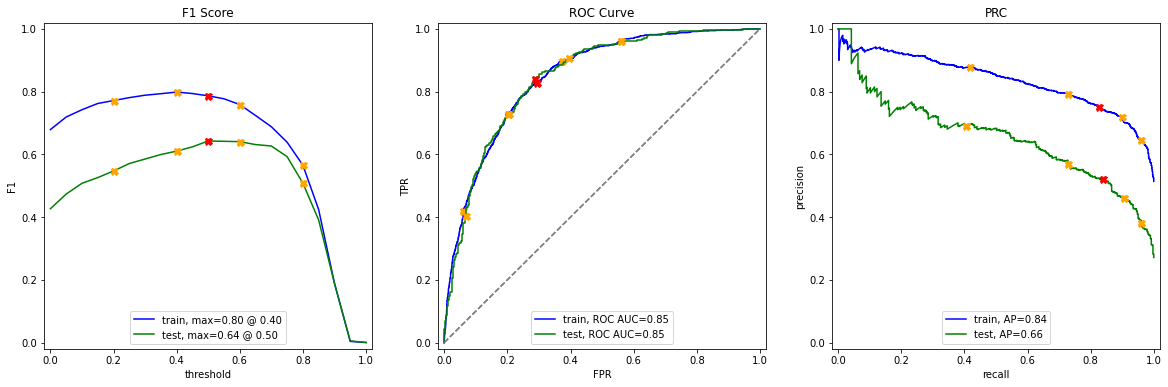

In [77]:
model_lr3 = LogisticRegression(random_state=12345)
model_lr3.fit(x_train_up_stand, up_y_train)
evaluate_model(model_lr3, x_train_up_stand, up_y_train, x_val_stand, y_val)

* For LogisticRegression with Encoded, upsample, and Standardized data:
    * AOC ROC is 0.85 for both the test and the train set
    * The Accuracy is 0.73 which is the same as the base line model 
    * There is a big difference between the test set and the train set for F1 and APS score.

**RandomForestClassifier with 10 estimators and max depth of 8, for upsampled data and normalized features:**

          train  test
Accuracy   0.85  0.75
F1         0.86  0.64
APS        0.90  0.66
ROC AUC    0.91  0.85


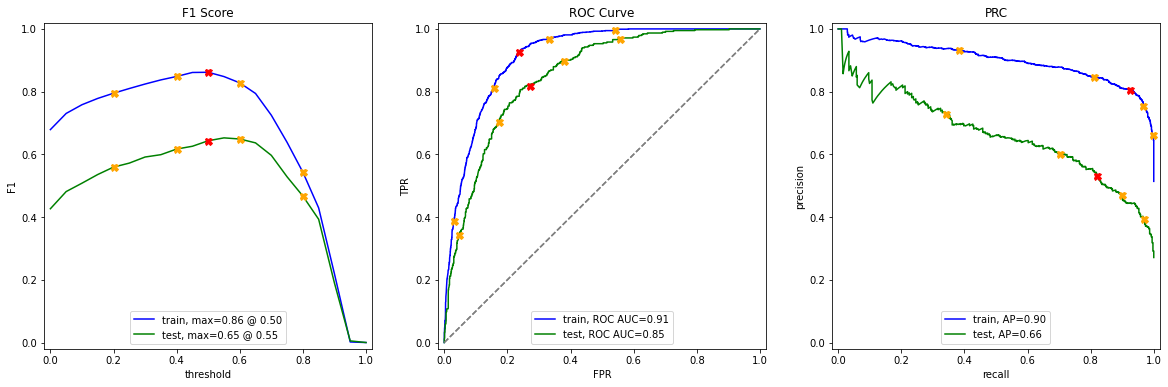

In [78]:
rf_model = RandomForestClassifier(random_state=12345,
                                  n_estimators= 10,
                                  max_depth=8)
rf_model.fit(x_train_up_norm, up_y_train)
evaluate_model(rf_model, x_train_up_norm, up_y_train, x_val_norm, y_val)

* For RandomForestClassifier with 10 estimators and max depth of 8, for upsampled data and normalized data:
    * AOC ROC is 0.85 for the test and 0.93 for the train set, it could indicat that there are observation in the test set that the model haven't seen before
    * The Accuracy is 0.85 for the train and 0.76 for the test which is pretty close to the base line model 
    * There is a big difference between the test set and the train set for F1 and APS score.

**RandomForestClassifier with 8 estimators and max depth of 9, for upsampled data and Standardized features:**

          train  test
Accuracy   0.87  0.76
F1         0.88  0.65
APS        0.92  0.65
ROC AUC    0.93  0.85


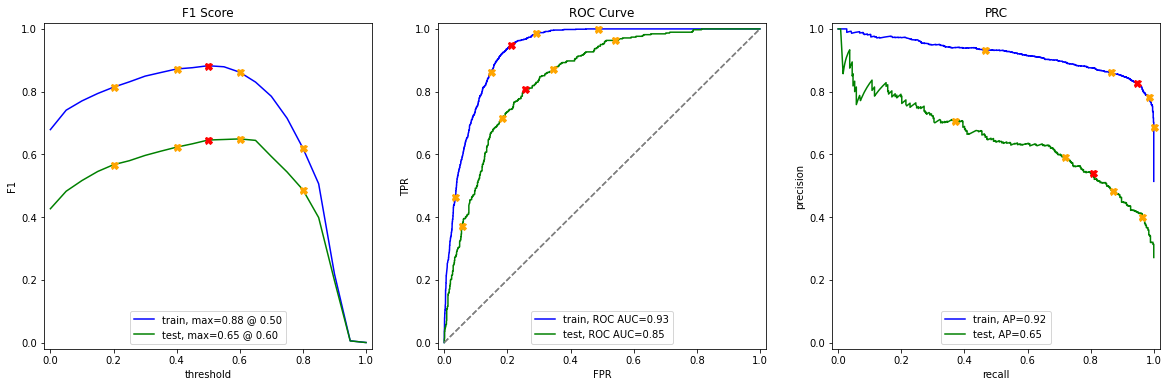

In [79]:
rf1_model = RandomForestClassifier(random_state=12345,
                                  n_estimators= 8,
                                  max_depth= 9)
rf1_model.fit(x_train_up_stand, up_y_train)
evaluate_model(rf1_model, x_train_up_stand, up_y_train, x_val_stand, y_val)

* For RandomForestClassifier with 8 estimators and max depth of 9, for upsampled data and Standardized data:
    * The metrics are almost the same as before. 

**CatBoostClassifier with  lr of 0.3, 10 estimators and max depth of 5, for upsampled data and normalized features:**

          train  test
Accuracy   0.78  0.74
F1         0.80  0.64
APS        0.85  0.67
ROC AUC    0.86  0.85


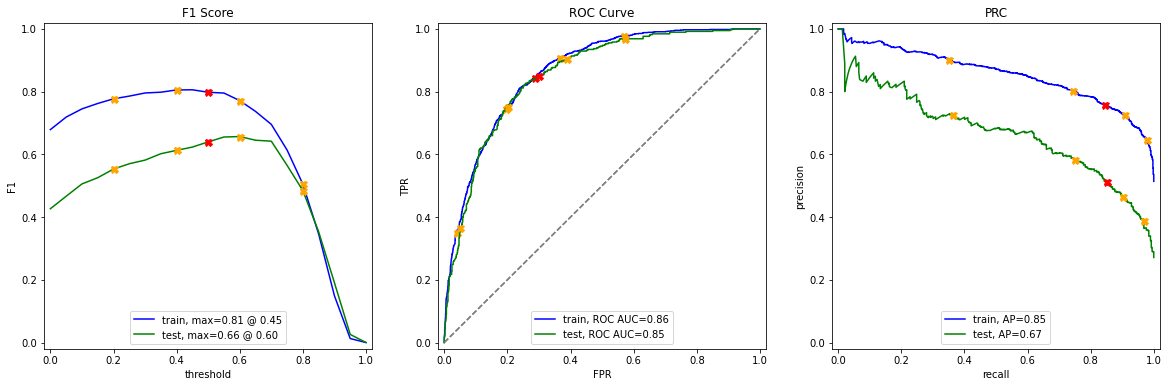

In [80]:
cb1_model = CatBoostClassifier(learning_rate=0.3,               
                              random_seed=12345,
                              verbose=False,
                              max_depth=5,
                              n_estimators=10)

cb1_model.fit(x_train_up_norm, up_y_train)

evaluate_model(cb1_model, x_train_up_norm, up_y_train, x_val_norm, y_val)

* For CatBoostClassifier with lr of 0.3, 10 estimators and max depth of 5, for upsampled and normalized data:
    * The AOC ROC score for the test set is 0.85 
    * The Accuracy is is pretty close to the base line model
    * There is a big diffrence for the F1 and APs score between the train and the test sets. 

**CatBoostClassifier with  lr of 0.1, 10 estimators and max depth of 12, for Standardized features:**

          train  test
Accuracy   0.81  0.74
F1         0.72  0.62
APS        0.82  0.65
ROC AUC    0.93  0.84


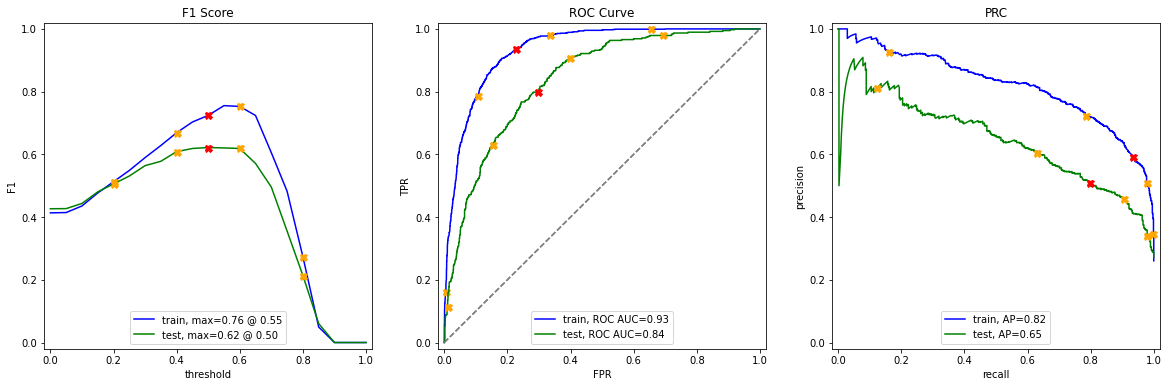

In [81]:
cb2_model = CatBoostClassifier(learning_rate=0.1,               
                              random_seed=12345,
                              class_weights=(1,3),
                              verbose=False,
                              max_depth=12,
                              n_estimators=10)

cb2_model.fit(x_train_stand, y_train)

evaluate_model(cb2_model, x_train_stand, y_train, x_val_stand, y_val)

* For CatBoostClassifier with  lr of 0.1, 10 estimators and max depth of 12, for Standardized data: 
    * The AOC ROC is 0.85
    * The Accuracy is lower then the base line.

**CatBoostClassifier with  lr of 0.1, 10 estimators and max depth of 10, for upsampled data and Standardized features:**

          train  test
Accuracy   0.83  0.75
F1         0.84  0.64
APS        0.89  0.66
ROC AUC    0.91  0.84


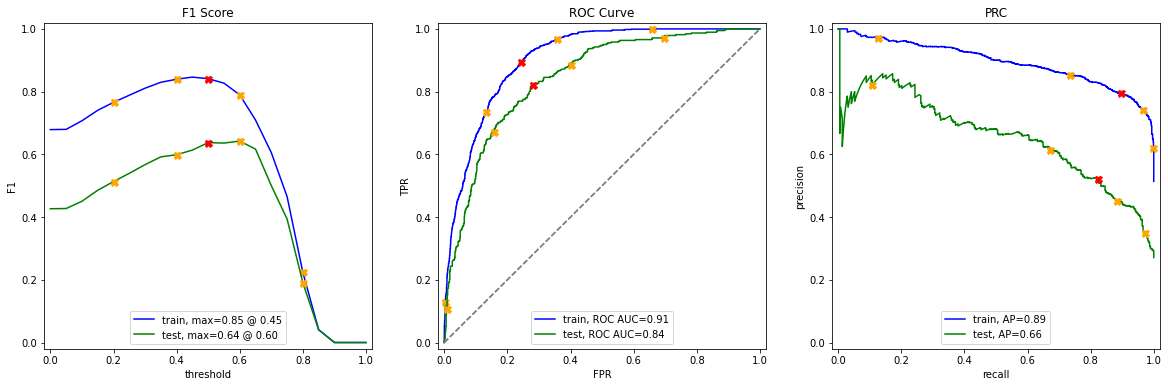

In [82]:
cb_model = CatBoostClassifier(learning_rate=0.1,               
                              random_seed=12345,
                              verbose=False,
                              max_depth=10,
                              n_estimators=10)

cb_model.fit(x_train_up_stand, up_y_train)

evaluate_model(cb_model, x_train_up_stand, up_y_train, x_val_stand, y_val)

* For CatBoostClassifier with lr of 0.1, 10 estimators and max depth of 10, for upsampled data and Standardized data: 
    * The AOC ROC is 0.85
    * The Accuracy is the same as the base line.

**After we examine the models preformences, maybe divide the orignal data base into three part was not the best option, lets try Cross validation, meybe increasing the train set will yield better results:**


In [83]:
df2 = merge.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
x2 = df2.drop(['target'], axis=1)
y2 = df['target']

In [84]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=12345)

**Define model_eval function, that calculate the accuracy and the AOC ROC for a given model:**

In [85]:
def model_eval(model, x_train, y_train):
   
    ohe = OneHotEncoder()
    scale = MinMaxScaler()

    preprocess = make_column_transformer((ohe, ['Type', 'PaymentMethod']),
                                         (scale, ['MonthlyCharges','TotalCharges','ContractDuration']),
                                         remainder='passthrough')

    oversample = RandomOverSampler()

    steps = [('preprocess', preprocess), ('upsample', oversample), ('model', model)]
    pipeline = Pipeline(steps)

    scores = cross_validate(pipeline, x_train, y_train,  cv=3, scoring=['roc_auc', 'accuracy'], verbose= True, error_score='raise')
    print('roc_auc:', scores['test_roc_auc'])
    print('roc_auc mean:', scores['test_roc_auc'].mean())
    print('accuracy:',scores['test_accuracy'])
    print('accuracy mean:', scores['test_accuracy'].mean())

In [86]:
model_eval(LogisticRegression(random_state=12345), x2_train, y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


roc_auc: [0.82806081 0.84951927 0.83359097]
roc_auc mean: 0.8370570193147433
accuracy: [0.72949947 0.75239617 0.73375932]
accuracy mean: 0.7385516506922256


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


In [87]:
model_eval(RandomForestClassifier(random_state=12345,
                                  n_estimators= 8,
                                  max_depth= 9), x2_train, y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


roc_auc: [0.82410077 0.84077965 0.82343809]
roc_auc mean: 0.8294395041149913
accuracy: [0.75186368 0.75665602 0.73748669]
accuracy mean: 0.7486687965921193


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


In [88]:
model_eval(CatBoostClassifier(learning_rate=0.3,               
                              random_seed=12345,
                              verbose=False,
                              max_depth=5,
                              n_estimators=10), x2_train, y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


roc_auc: [0.83924653 0.85140168 0.84205596]
roc_auc mean: 0.8442347219607246
accuracy: [0.74494143 0.7571885  0.74440895]
accuracy mean: 0.7488462903798366


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


In [89]:
model_eval(CatBoostClassifier(learning_rate=0.1,               
                              random_seed=12345,
                              verbose=False,
                              max_depth=3,
                              n_estimators=10) ,x2_train,y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


roc_auc: [0.83063641 0.84453062 0.83521695]
roc_auc mean: 0.8367946579895763
accuracy: [0.72151225 0.72257721 0.70394036]
accuracy mean: 0.7160099396521122


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


**Split the original dataset into 2, and using Cross Validation to asses the model preformences yeild the same results as first approach.**

#### Mid conclution:
We got the best results for splitng the data into 3 sets, for RandomForestClassifier with 8 estimators and max depth of 9, with upsampled data and Standardized data.
* Accuracy:  0.87(train), 0.76(validation)
* F1: 0.88(train), 0.65(validation)
* APS: 0.92(train), 0.65(validation)
* ROC AUC: 0.93(train), 0.85(validation)

* We need to check the model preformence on the test set:

          train  test
Accuracy   0.87  0.73
F1         0.88  0.60
APS        0.92  0.61
ROC AUC    0.93  0.81


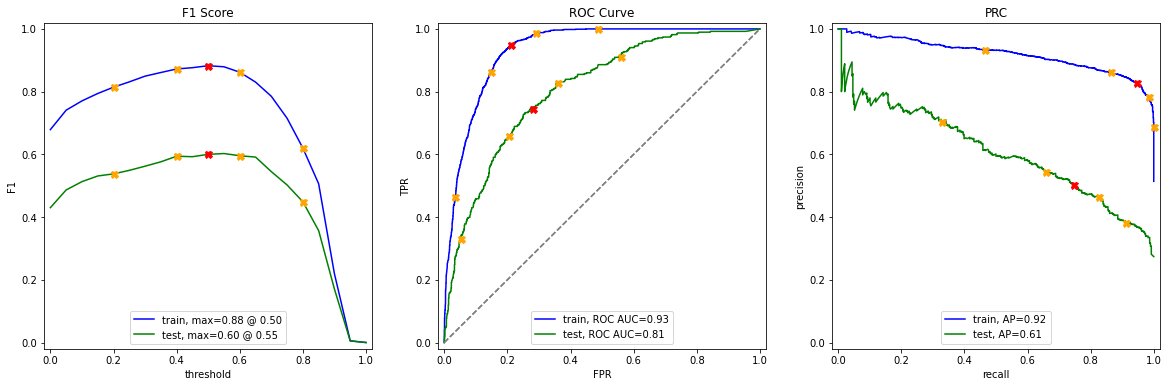

In [90]:
evaluate_model(rf1_model, x_train_up_stand, up_y_train, x_test_stand, y_test)

* We got ROC AUC score of 0.81 on the test set, and 0.93 on the traun set with RandomForestClassifier with 8 estimators= 8, and max depth of 9.
